### <a href="https://www5.cs.fau.de/fileadmin/research/datasets/fundus-images/all.zip">Dataset</a>

## Load dataset

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
import segmentation_models as sm
# if you get an errror: module 'keras.utils.generic_utils' has no attribute 'get_custom_objects'
# open keras.py and change all 'init_keras_custom_objects' to 'init_tfkeras_custom_objects'

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from preprocess import train_val_test_split
sys.path.append('../')
from load_images import load

In [12]:
img_size = (512, 512)
X, y, _ = load(img_size)

## Preprocessing + creating generators

In [13]:
batch_size = 2

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X,y)

train_datagen = ImageDataGenerator()
        #rotation_range=20, # Data Augmentation ?
        #zoom_range=0.2,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #horizontal_flip=True,
        #vertical_flip=True)

val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

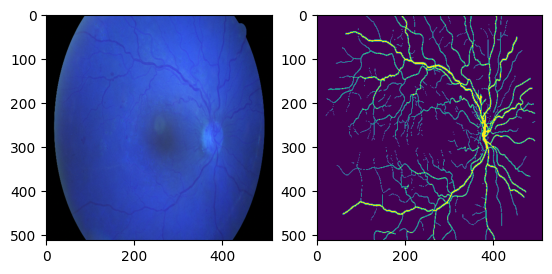

In [14]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(val_generator[0][0][0], cmap='gray')
ax[1].imshow(val_generator[0][1][0])
plt.show()

## Plot callback

In [15]:
class PlotCallback(Callback):
    def __init__(self, val_generator, title, num_epochs=1):
        super(PlotCallback, self).__init__()
        self.val_generator = val_generator
        self.num_epochs = num_epochs
        self.title = title

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.num_epochs == 0:
            val_images, val_masks = next(iter(self.val_generator))
            predicted_masks = self.model.predict(val_images)
            
            fig, ax = plt.subplots(1, 3, figsize=(8, 4))
            
            ax[0].imshow(val_images[0][:,:,1])
            ax[0].set_title("Ground Truth")

            ax[1].imshow(val_masks[0])
            ax[1].set_title("Mask")

            ax[2].imshow(predicted_masks[0])
            ax[2].set_title("Predicted")

            fig.suptitle(self.title)
            fig.tight_layout()
            plt.subplots_adjust(hspace=0.1)
            plt.show()
            

## Training

Epoch 1/2


2023-05-28 11:33:06.983496: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


15/15 [==============================] - 9s 299ms/step - loss: 0.0661 - accuracy: 0.9769 - val_loss: 0.0729 - val_accuracy: 0.9744
Epoch 2/2
1/1 [==============================] - 1s 643ms/steposs: 0.0622 - accuracy: 0.97


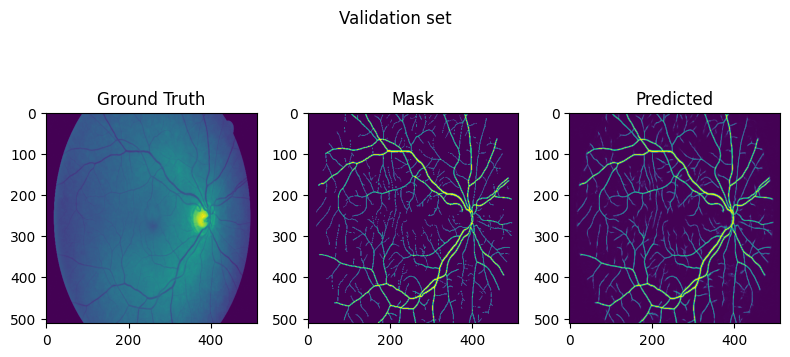

15/15 [==============================] - 5s 318ms/step - loss: 0.0622 - accuracy: 0.9782 - val_loss: 0.0721 - val_accuracy: 0.9746


In [18]:
model = sm.Unet('efficientnetb0', classes=1, activation='sigmoid')
model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.load_weights('unet_effnetb0.h5') # comment this line if no training was performed previously

history = model.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[PlotCallback(val_generator, title='Validation set', num_epochs=2),
              ModelCheckpoint('unet_effnetb0_.h5', save_best_only=True)],
              #PlotCallback(train_generator, title='Train set', num_epochs=1)],
    epochs=2
)

## Results
#### Accuracy and loss during training

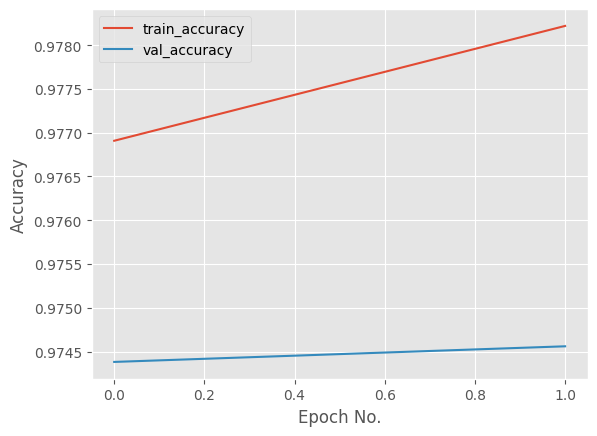

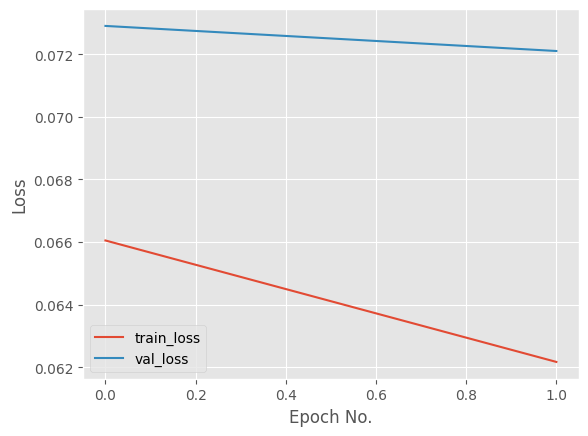

In [40]:
plt.style.use('ggplot')

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch No.')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Loss')
plt.xlabel('Epoch No.')
plt.legend()
plt.show()

#### Classification report on test set

In [36]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()
y_test = y_test.flatten()
_, y_pred = cv2.threshold(y_pred, 0.5, 1, cv2.THRESH_BINARY)
y_pred = y_pred.astype(np.uint8)

1/1 [==============================] - 0s 20ms/step


In [39]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99   1214857
           1       0.80      0.84      0.82     95863

    accuracy                           0.97   1310720
   macro avg       0.90      0.91      0.90   1310720
weighted avg       0.97      0.97      0.97   1310720

